# Проект: Статистический анализ данных

**Цель работы**: сделать анализ данных сервиса аренды проката самокатов на определение "слабых сторон" в бизнесе и дать комментарии его улучшению.

**Задачи**, которые необходимо решить:
1. Проверить на существование зависимости частоты использования проката от:
   - возраста пользователей;
   - территориального нахождения прокатного салона;
   - расстояния одной поездки пользователя;
   - времени продолжительности одной поездки.
2. Определить соотношение пользователей, у которых есть подписка и без неё.
3. Установить, оказывает ли влияние подписки на показатели, описанные в п.1
4. Исследовать данные о пользователях, у которых есть подписка: 
   - определить тратят ли они времени за одну поездку больше, чем пользователи без подписки;
   - приходят ли в негодность самокаты у таких пользвателей чаще, чем у пользователей без подписки, сопоставив дистанцию одной поездки с расстоянием в 3130 м (критическое расстояние износа самоката)
   - является ли помесячная выручка пользователей с подпиской больше, чем без неё.

Для решение задач, первоначально, необходимо:
1. Сделать обзор полученных данных о прокате самокатов.
2. Провести предобработку данных на выявление пропусков и дубликатов(явных и неявных)
3. Создать датафрейм по всем данным и отдельные датафреймы по данным только для подписчиков и пользователей без подписки.
Также полученные данные преставлять в виде графиков, для наглядности и простоты восприятия полученной информации.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

#### Шаг 1. Загрузка данных
1. Прочитать файлы и сохранить их.
2. Вывести первые 10 строк и общую информацию о них
3. Сделать вывод об информации в данных фвйлах

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv') #файл с данными о пользователях

In [3]:
display(data_users.head(10))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
print(data_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


In [5]:
data_rides = pd.read_csv('/datasets/rides_go.csv') #файл с данными о поездках

In [6]:
display(data_rides.head(10))

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [7]:
print(data_rides.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


In [8]:
data_sub = pd.read_csv('/datasets/subscriptions_go.csv') #файл с данными о подписках

In [9]:
display(data_sub.head(10))

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
print(data_sub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


Вывод:из полученных файлов видно, что необходимо:
1. файл с данными о пользователях:
   - проверить на дубликаты название городов, имена и подписки;
   - проверить на дупликаты строк, если они есть и их количество не полияет на данные, удалить;
   - проверить на пропуски, если есть, посмотреть возможно ли заменить, или придется их оставить или удалить.
2. файл с данными о поездках:
   - поменять тип данных колонки время;
   - создать новую колонку с месяцами и проверить какой период по времени(годы) приведены в данных;
   - проверить на дупликаты строк, если они есть и их количество не полияет на данные, удалить;
   - проверить на пропуски,если есть, посмотреть возможна ли замена или их придется оставлять или удалять.
3. файл с данными о подписках:
   - данные не нуждаются в предобработке.

#### Шаг 2. Предобработка данных

##### Выполним предобработку файла с данными о пользователях.
Первое, что необходимо сделать при предобработке данных, определим сколько пропусков есть в каждой категории.

In [11]:
print(data_users.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


Выяснилось, что пропусков нет. Проверим на наличие дубликатов в данном файле.

In [12]:
print (data_users['city'].unique())

['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи']


In [13]:
print (data_users['subscription_type'].unique())

['ultra' 'free']


In [14]:
print (data_users['name'].unique())

['Кира' 'Станислав' 'Алексей' 'Константин' 'Адель' 'Регина' 'Игорь' 'Юрий'
 'Ян' 'Валерий' 'Агата' 'Марк' 'Ева' 'Антонина' 'Валерия' 'Амалия'
 'Даниил' 'Аделина' 'Святогор' 'Борис' 'Вероника' 'Ростислав' 'Назар'
 'Эдуард' 'Василий' 'Денис' 'Тамара' 'Николай' 'Эвелина' 'Федор' 'Руслан'
 'Иван' 'Любовь' 'Ярослава' 'Майя' 'Ильдар' 'Данила' 'Нина' 'Стефания'
 'Ясмина' 'Дмитрий' 'Александр' 'Одиссей' 'Арсений' 'Алла' 'Таисия'
 'Максим' 'Юлиана' 'Павел' 'Карина' 'Алиса' 'Лидия' 'Рамиль' 'Родион'
 'Ника' 'Оксана' 'Анастасия' 'Маргарита' 'Вера' 'Тимур' 'Никита' 'Лев'
 'Влад' 'Артур' 'Анна' 'Ольга' 'Вячеслав' 'Ксения' 'Виталина' 'Владислав'
 'Тамерлан' 'Амина' 'Вадим' 'Олеся' 'Зарина' 'Егор' 'Гордей' 'Лилия'
 'Святослав' 'Роберт' 'Амир' 'Влада' 'Богдан' 'Полина' 'Марат' 'Елисей'
 'Макар' 'Алина' 'Глеб' 'Андрей' 'Альбина' 'Людмила' 'Марсель' 'Милена'
 'Диана' 'Дарина' 'Данил' 'Артемий' 'Лиана' 'Альберт' 'Герман' 'Жанна'
 'Нелли' 'Евгения' 'Ариана' 'Самира' 'Захар' 'Эльвира' 'Екатерина' 'Инна'
 '

In [15]:
print (data_users['age'].unique()) 

[22 31 20 26 28 25 23 21 18 27 24 29 32 14 19 30 17 12 35 33 13 15 37 16
 34 38 36 39 43]


In [16]:
print(data_users.shape[0])
print(data_users.duplicated().sum())

1565
31


In [17]:
data_users = data_users.drop_duplicates().reset_index(drop = True)

Вывод: файл с данными о пользователях содержал дублирующиеся строки (31 из 1565, это составляет 2% от всех данных), было принято решение их удалить.

##### Выполним предобработку файла с данными о поездках.
Первое, что необходимо сделать при предобработке данных, определим сколько пропусков есть в каждой категории.

In [18]:
print(data_rides.isna().sum())

user_id     0
distance    0
duration    0
date        0
dtype: int64


Пропусков нет. Изменим тип данных в колонке со временем и создадим отдельную колонку с месяцами.

In [19]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format = '%Y-%m-%d')

In [20]:
data_rides['month'] = pd.DatetimeIndex(data_rides['date']).month

In [21]:
print(pd.DatetimeIndex(data_rides['date']).year.value_counts()) #проверка на уникальность даты по годам

2021    18068
Name: date, dtype: int64


Проверим на наличие дубликатов.

In [22]:
print(data_rides.shape[0])
print(data_rides.duplicated().sum())

18068
0


Вывод: 
- в файле с данными о поездках был изменен тип данных в датах и создана новая колонка с месяцами; 
- было установлено, что данные предсталенны только за 2021 год (не надо учитывать вклад месяцов в другие года, если они были бы);
- дубликаты строк не были обнаружены.

##### Вывод: 
Было установлено, что файлы, практически, не нуждаются в предоработке данных, кроме данных с датами и дубликатами из файла про пользователи. Необходимо было сменить тип данных и добавить новый столбец для месяцев. 

Было установлено, что данные приведены за 2021 год, что упрощает оценку по месяцам(не учета по разным годам). 

В файле про пользователей были удалены дублирующиеся строки (с последующим обнавлением индексов), поскольку они составляли 2% от всех данных.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов
Определить в каких городах прокатом пользуются чаще по отношению к другим и посмотреть сколько в среднем пользователей есть.

Среднее количество ползователей = 191


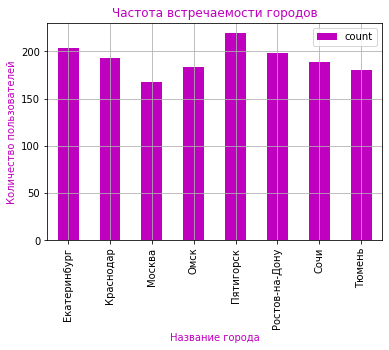

In [23]:
city = data_users.loc[:, ['city', 'user_id']]
city_new = city.pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
city_new.columns = ['count']
#print(city_new.sort_values(by = 'count',ascending = False).head(10))
print('Среднее количество ползователей =',int(city_new['count'].mean()))
city_new.plot(kind = 'bar', grid = True, color = 'm');
plt.xlabel('Название города', color = 'm')
plt.ylabel('Количество пользователей', color = 'm')
plt.title('Частота встречаемости городов', color='m')

plt.show()

###### Вывод:
Исходя из построенного графика распределения количества ползователей в зависимости от городов было установлено, что больше всего прокатом пользуются в Пятигорске, минимальное пользование прокатов в Москве. Среднее количевтво пользователей в городах: 191.

##### Cоотношение пользователей с подпиской и без подписки
Построить круговую диаграмму зависимостри количества пользователей от вида их подписки в целом и в зависимости от города.

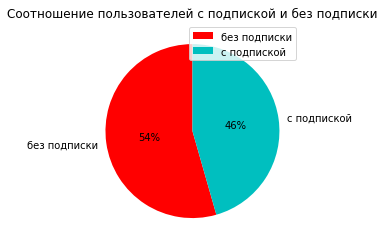

In [24]:
type_0 = data_users.loc[:, ['user_id','subscription_type']]
type_new = type_0.pivot_table(index = 'subscription_type', values = 'user_id', aggfunc = 'count')
type_new.columns = ['count']
type_new.plot(
    kind = 'pie', labels = ['без подписки', 'с подпиской'],subplots=True, startangle=90,pctdistance=0.5,
    colors=["r", "c"],
    autopct="%.f%%",
);
plt.ylabel("")
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.show()

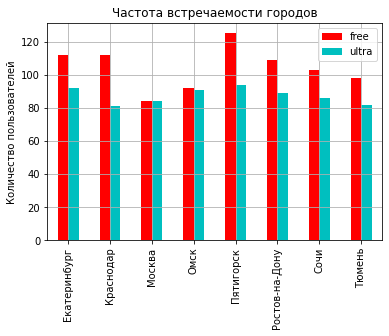

In [25]:
type_1 = data_users.loc[:, ['user_id', 'city', 'subscription_type']]
type_new1 = type_1.query('subscription_type == "free"').pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
type_new2 = type_1.query('subscription_type == "ultra"').pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
type_new1.columns = ['free']
type_new2.columns = ['ultra']
type_11 = type_new1.join(type_new2)
type_11.plot(
    kind = 'bar', grid = True, color = ['r', 'c']);
plt.xlabel('')
plt.ylabel('Количество пользователей')
plt.title('Частота встречаемости городов')
plt.show()

###### Вывод: 
 Исходя из полученных данных распределение пользователей с подпиской, практически, одинакова. Разница составляет, приблизительно, 8% в пользу пользователей, у которых нет подписки. 
 Из данных по сотношению пользователей с подпиской или без в зависимости от города наблюдается что:
- во всех городах количество пользователей с подпиской меньше чем без неё;
- количество пользователей с подпиской во всех городах имеют небольшой разброс, в отличие от количества пользователей без потписки.

##### Возраст пользователей
Для исследования влияния возраста посетителей на прокат построим круговую гистограмму и определим в какой городе какие диапазоны возраста предпостительней

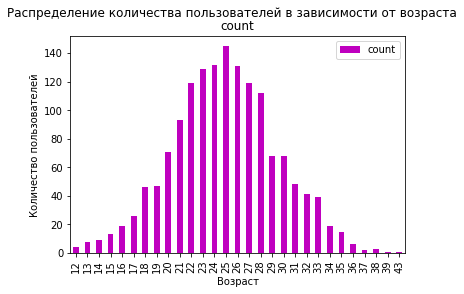

In [26]:
age_0 = data_users.loc[:, ['user_id','age']]
age_new = age_0.pivot_table(index = 'age', values = 'user_id', aggfunc = 'count')
age_new.columns = ['count']
age_new.plot(
    kind = 'bar', 
    subplots=True, color = 'm',
    title = 'Распределение количества пользователей в зависимости от возраста',
);
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

In [27]:
#data_rides['duration'].describe()

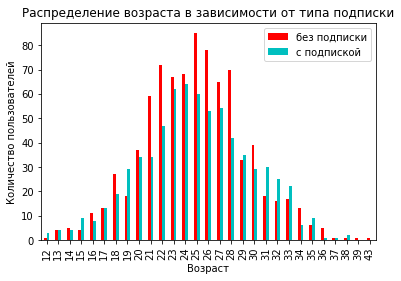

In [28]:
age_1 = data_users.loc[:, ['user_id', 'age', 'subscription_type']]
age_new1 = age_1.query('subscription_type == "free"').pivot_table(index = 'age', values = 'user_id', aggfunc = 'count')
age_new2 = age_1.query('subscription_type == "ultra"').pivot_table(index = 'age', values = 'user_id', aggfunc = 'count')
age_new1.columns = ['free']
age_new2.columns = ['ultra']
age_11 = age_new1.join(age_new2)
age_11.plot(
    kind = 'bar',color = ['red', 'c'],
    title = 'Распределение возраста в зависимости от типа подписки');
plt.legend(['без подписки', 'с подпиской'])
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

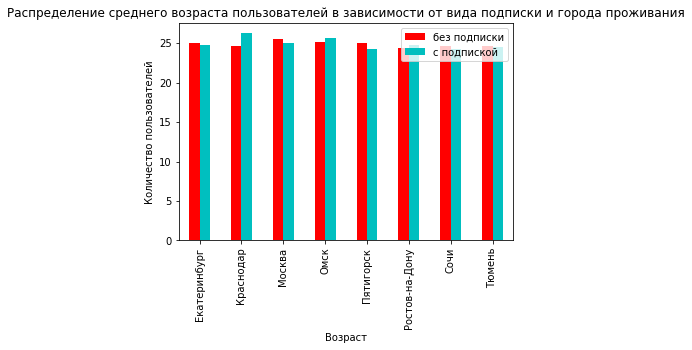

In [29]:
age_1 = data_users.loc[:, ['age', 'city', 'subscription_type']]
age_new1 = age_1.query('subscription_type == "free"').pivot_table(index = 'city', values = 'age', aggfunc = 'mean')
age_new2 = age_1.query('subscription_type == "ultra"').pivot_table(index = 'city', values = 'age', aggfunc = 'mean')
age_new1.columns = ['free']
age_new2.columns = ['ultra']
age_11 = age_new1.join(age_new2)
age_11.plot(
    kind = 'bar',color = ['red', 'c'],
    title = 'Распределение среднего возраста пользователей в зависимости от вида подписки и города проживания');
plt.legend(['без подписки', 'с подпиской'])
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

###### Вывод:
Из полученных данных видно,что 
- зависимость количества пользователей от возвраста представляет нормальное распределение, что говорит о корректности данных. По данному распределению больше всего пользуются прокатом люди в возрасте 25 лет;
- зависимость количества пользователей от возраста с учетом вида подписки не представляет нормальные распределения. Зависимость количества пользователей от возвраста, кто имеет подписку, представляет распределение Стьюдента, а зависимость количества пользователей от возвраста, кто не имеет подписку, имеют много скачков в окрестностях пика, поэтому нельхя сказать, что распределение нормальное. Но данные скачки вносят вклад в распределение без учёта подписки, что сказывается на среднем возрасте пользователей проката;
- зависимость среднего возраста ползователей с подписко и без нее в зависимости от города не показало значительных различий. Средний возвраст колеблится в районе 25 лет.

##### Расстояние, которое пользователь преодолел за одну поездку
Для изучение распределения расстояния за одну поездку пользователя построим гистограммы расстояний, которые пользователь преодалел за одну поездку, без учета вида подкиски и с учетом подписки. Сделаем выводы по полученным гистограммам и оценим влияние подписки на распределение.

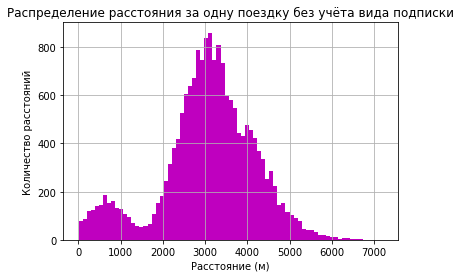

In [30]:
data_rides['distance'].hist(color = 'm', 
                            bins = 75);
plt.title('Распределение расстояния за одну поездку без учёта вида подписки');
plt.xlabel('Расстояние (м)');
plt.ylabel('Количество расстояний');

plt.show()


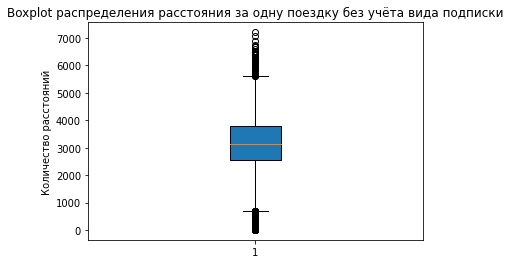

In [31]:
plt.boxplot(data_rides['distance'], patch_artist=True);
plt.title('Boxplot распределения расстояния за одну поездку без учёта вида подписки');
plt.ylabel('Количество расстояний');

In [32]:
#data_rides['distance'].describe()

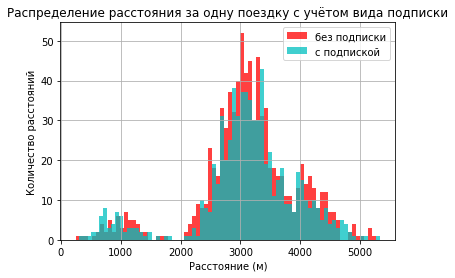

In [33]:
data_rides['sub'] = data_users['subscription_type']
plt.hist(data_rides.query('sub == "free"')['distance'], color = 'r',alpha = 0.75, label='без подписки', bins = 75)
plt.hist(data_rides.query('sub == "ultra"')['distance'],color = 'c', alpha = 0.75, label='с подпиской', bins = 75)
plt.legend()
plt.title('Распределение расстояния за одну поездку с учётом вида подписки');
plt.grid(b=True)
plt.xlabel('Расстояние (м)');
plt.ylabel('Количество расстояний');
plt.show()

###### Вывод:
- Основная часть поездок занимает от 2543 до 3776 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м.
- зависимость количества пользователей от возвраста представляет нормальное распределение, что говорит о корректности данных. По данному распределению больше всего пользуются прокатом люди в возрасте 25 лет;
- зависимость количества пользователей от возраста с учетом вида подписки не представляет нормальные распределения. Зависимость количества пользователей от возвраста, кто имеет подписку, представляет распределение Стьюдента, а зависимость количества пользователей от возвраста, кто не имеет подписку, имеют много скачков в окрестностях пика, поэтому нельхя сказать, что распределение нормальное. Но данные скачки вносят вклад в распределение без учёта подписки, что сказывается на среднем возрасте пользователей проката;
- зависимость среднего возраста ползователей с подпиской и без нее в зависимости от города не показало значительных различий. Средний возвраст колеблится в районе 25 лет.

##### Продолжительность поездок
Для изучение распределения продолжительности поездок пользователя построим гистограммы продолжительности без учета вида подкиски и с учетом подписки. Сделаем выводы по полученным гистограммам и оценим влияние подписки на распределение.

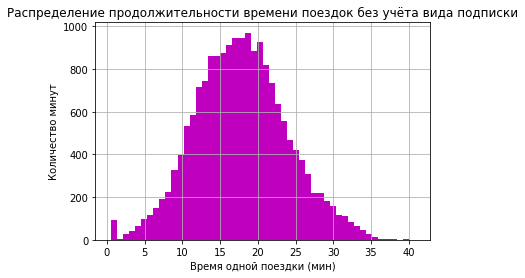

In [34]:
data_rides['duration'].hist(color = 'm', 
                            bins = 50);
plt.title('Распределение продолжительности времени поездок без учёта вида подписки');
plt.xlabel('Время одной поездки (мин)');
plt.ylabel('Количество минут');

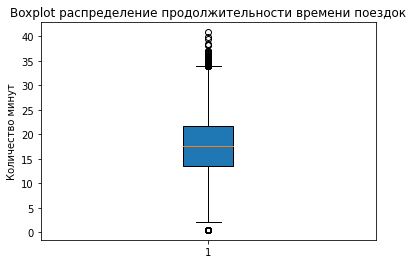

In [35]:
plt.boxplot(data_rides['duration'], patch_artist=True);
plt.title('Boxplot распределение продолжительности времени поездок');
plt.ylabel('Количество минут');

In [36]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

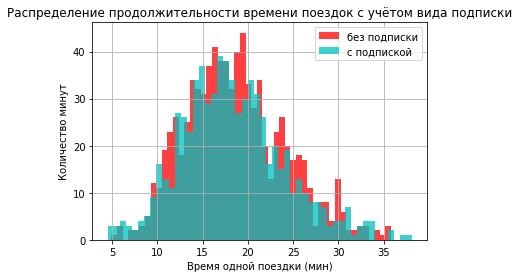

In [37]:
plt.hist(data_rides.query('sub == "free"')['duration'], color = 'r',alpha = 0.75, label='без подписки', bins = 50)
plt.hist(data_rides.query('sub == "ultra"')['duration'],color = 'c', alpha = 0.75, label='с подпиской', bins = 50)
plt.legend()
plt.title('Распределение продолжительности времени поездок с учётом вида подписки');
plt.grid(b=True)
plt.xlabel('Время одной поездки (мин)');
plt.ylabel('Количество минут');
plt.show()

###### Вывод:
Исходя из полученных данных наблюдается нормальное распределение но с выбросами. Основная часть поездок занимает от 13 до 22 минут. Медиана 18 минут. Аномальный выброс наблюдается при значении расстояния равным 0.5 мин. 
При построении гистограммы распределения продолжительности поездок с учётом влияния видов подписки было установлено, что в аномальный пик при значениях близких к 0,больше вносят вклад те пользователи, которые имеют подписку.Но на все распредление вносят те данные, пользователи которых не имеют подписку.

#### Шаг 4. Объединение данных
На данном этапе необходимо сделать:
- Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().
- Создайте ещё два датафрейма из датафрейма, созданного на предыдущем этапе:
  - c данными о пользователях без подписки;
  - с данными о пользователях с подпиской.
- построение повторного распределения времени и расстояния в зависимости от типа поездки, дополнить вывод о полученных результатах.

После создание датафреймов провести проверку размерности.

In [38]:
data = data_users.merge(data_rides).drop('sub', axis = 1)
display(data.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [39]:
len(data_users)

1534

In [40]:
len(data_rides)

18068

In [41]:
len(data)

18068

In [42]:
print('Количество явных дубликатов в датафрейме "data" = ', data.duplicated().sum(), '\n')
data.info()

Количество явных дубликатов в датафрейме "data" =  0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


In [43]:
data_free = data.query('subscription_type == "free"')
display(data_free.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2


In [44]:
data_ultra = data.query('subscription_type == "ultra"')
display(data_ultra.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [45]:
if len(data) == (len(data_free) + len(data_ultra)):
    print('Разделение прошло успешно')
else:
    print('ВНИМАНИЕ! Разделение не получилось, есть ошибка в коде')

Разделение прошло успешно


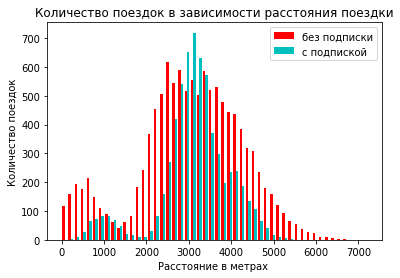

In [46]:
plt.hist([data_free['distance'], data_ultra['distance']],color = ['red', 'c'], bins=50, label=['без подписки', 'с подпиской'])
plt.legend(loc='upper right')
plt.title('Количество поездок в зависимости расстояния поездки')
plt.xlabel('Расстояние в метрах ')
plt.ylabel('Количество поездок')
plt.show()

In [47]:
data_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [48]:
data_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

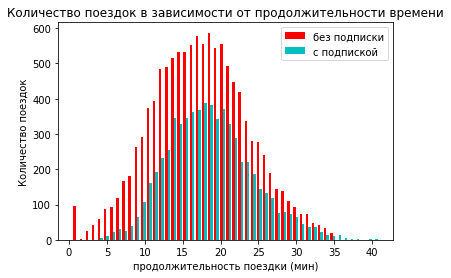

In [49]:
plt.hist([data_free['duration'], data_ultra['duration']],color = ['red', 'c'], bins=50, label=['без подписки', 'с подпиской'])
plt.legend(loc='upper right')
plt.title('Количество поездок в зависимости от продолжительности времени')
plt.xlabel('продолжительность поездки (мин)')
plt.ylabel('Количество поездок')
plt.show()

In [50]:
data_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [51]:
data_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

##### Вывод:
С помощью метода merge() был создан датафрейм, объединяющий всех пользователей.

С помощью метода query() были созданы датафреймы, в которых данные только о тельзователях, у которых нет подписки или она есть.

Была выполнена оценка корректности разделение. Разделение было совершено корректно.

Были построены распределения для расстояния и времени одной поездки в зависимости от типа подписки. Распределения повторяют то, что было представлено в пункте 3. Но было установлено, что у пользователей без подписки минимальное время составляет 0.5 минуты, минимальное расстояние за одну поездку - 0.8 метров. Это может свидетельствовать о проблемах во внутреннней структуре использования самокатов без подписки и неисправности самих самокатов.

#### Шаг 5. Подсчёт выручки
Для подсчёт вырочки необходимо:
- Создать датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
- В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа методом ceil()

Замечание:перед расчётом выручки провести проверку на пропуски

In [52]:
rev_free = data_free.pivot_table(index=['user_id', 'month'],values=['distance', 'duration'],aggfunc={'distance': ["count","sum"], 'duration': "sum"} )
rev_free.columns = ['count','distance', 'duration']
print(rev_free.isna().sum()) #проверка пропусков

count       0
distance    0
duration    0
dtype: int64


In [53]:
rev_free['duration'] = np.ceil(rev_free['duration'])
rev_free['revenue'] = data_sub.loc[0,'start_ride_price']*rev_free['count'] + data_sub.loc[0,'minute_price']*rev_free['duration'] +  data_sub.loc[0,'subscription_fee']
display(rev_free.head(20))

count      distance  duration  revenue
user_id month                                        
700     1          1   2515.690719      15.0    170.0
        2          5  13446.659764      86.0    938.0
        3          1   3798.334905      19.0    202.0
        4          1   2984.551206      16.0    178.0
        6          2   5927.650988      29.0    332.0
        7          2   4399.206279      21.0    268.0
        8          1   4071.654669      17.0    186.0
        10         2   6322.578618      43.0    444.0
        11         3   8735.782625      32.0    406.0
701     1          1   2676.472894      18.0    194.0
        2          2   5637.334007      27.0    316.0
        3          1   2802.021357      17.0    186.0
        4          1   3509.012965      14.0    162.0
        5          1   2465.852577      15.0    170.0
        6          2   4634.620760      26.0    308.0
        7          4  12970.722682      65.0    720.0
        8          2   7628.751294      18.0    244.0
        9          2   8659.573699      32.0    356.0
        10         2   8395.260013      43.0    444.0
        12         2   2773.396606      22.0    276.0

In [54]:
rev_ultra = data_ultra.pivot_table(index=['user_id', 'month'],values=['distance', 'duration'],aggfunc={'distance': ["count","sum"], 'duration': "sum"} )
rev_ultra.columns = ['count','distance', 'duration']
print(rev_ultra.isna().sum()) #проверка пропусков

count       0
distance    0
duration    0
dtype: int64


In [55]:
rev_ultra['duration'] = np.ceil(rev_ultra['duration'])
rev_ultra['revenue'] = data_sub.loc[1,'start_ride_price']*rev_ultra['count'] + data_sub.loc[1,'minute_price']*rev_ultra['duration'] +  data_sub.loc[1,'subscription_fee']
display(rev_ultra.head(20))

count      distance  duration  revenue
user_id month                                        
1       1          2   7027.511294      42.0    451.0
        4          1    754.159807       7.0    241.0
        8          2   6723.470560      45.0    469.0
        10         2   5809.911100      32.0    391.0
        11         3   7003.499363      54.0    523.0
        12         2   6751.629942      28.0    367.0
2       3          3  10187.723006      61.0    565.0
        4          2   6164.381824      40.0    439.0
        6          1   3255.338202      14.0    283.0
        7          2   6780.722964      47.0    481.0
        8          1    923.007439       7.0    241.0
        10         1   2824.636598      19.0    313.0
        12         1   3828.248580      12.0    271.0
3       1          1   3061.777147      13.0    277.0
        2          2   5421.152016      38.0    427.0
        4          1   2956.651632      21.0    325.0
        5          3   9064.026918      62.0    571.0
        7          3  10919.595403      66.0    595.0
        9          1   2891.012822      23.0    337.0
        12         1   2593.381928      13.0    277.0

In [56]:
print ('Выручка за 2021 год составила :',rev_free['revenue'].sum() + rev_ultra['revenue'].sum(), 'руб.')

Выручка за 2021 год составила : 3853677.0 руб.


#####  Вывод:
С помощью метода pivot_table() были созданы сводные таблицы для пользователей с подпиской и без нее. 

Была посчитана помесячная вырочка с каждого пользователя в зависимости от типа подписки. 

Общая сумма выручки за 2021 год составила 3 853 677 руб.

По полученным данным сложно сделать вывод,кто приносит больше прибыли: пользователи с подпиской или без неё.

#### Шаг 6. Проверка гипотез

##### Гипотеза 1. Тратят ли пользователи с подпиской больше времени на поездки?
Сформулируем гипотезу:
- H0: пользователи с подпиской тратят сколько же времени на прокат сколько и пользователи без подписки.
- H1: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки (если это верно, это выгодно скажется на бизнесе)

In [57]:
alpha = 0.05

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative = 'greater')

print(f' p-value: {results.pvalue}')

if results.pvalue < alpha :
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Нет оснований отвергнуть нулевую гипотезу')

 p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


###### Вывод:
P-value больше alpha и ttest показал, что нулевую гипотезу отвергаем. Следовательно, пользователи с подпиской "выгоднее", чем пользователи без нее. Владельцам протака необходимо задуматься об увеличении пользователей с подпиской.

##### Гипотеза 2.Не превышают ли пользователи за одну поездку расстояние, равное 3130 метров?
Сформулируем гипотезу:
- H0:растояние, преодоленное пользователем с подпиской не превышает 3130 метров
- H1: растояние, преодоленное пользователем с подпиской превышает 3130 метров

In [58]:
alpha = 0.05

optimal_value = 3130

results = st.ttest_1samp(data_ultra['distance'], optimal_value, alternative = 'greater')
                         
print(f' p-value: {results.pvalue}')

if results.pvalue < alpha :
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Нет оснований отвергнуть нулевую гипотезу')

 p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


###### Вывод:
P-value меньше alpha и ttest показал, что нет оснований отвергать нулевую гипотезу. Следовательно, расстояние,которое преодолевают пользователи с подпиской, равно 3130 м, значит у самокатов,которыми пользуются подписчики, меньше износ.

##### Гипотеза 3.  Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
Сформулируем гипотезу:
- H0:выручка с пользователей с подпиской не превышает выручки с пользователей без подписки
- H1: выручка с пользователей с подпиской больше, чем с пользователей без подписки

In [59]:
alpha = 0.05

results = st.ttest_ind(rev_ultra['revenue'], rev_free['revenue'], alternative = 'greater')

print(f' p-value: {results.pvalue}')

if results.pvalue < alpha :
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Нет оснований отвергнуть нулевую гипотезу')

 p-value: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


###### Вывод:
Проведя одностороннее тестирование гипотезы, p-value больше уровня значимости, что позволяет отвергнуть гипотезу.
Следовательно, группа с подписками приносит v выручки компании GoFast и им стоит задуматься о привлечении "подписчиков".

##### Гипотеза 4.  Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В данном случае рассматривается случай сопоставления новых данных старым, поэтому будем использовать метод scipy.stats.ttest_rel(). Поскольку интересует снижение количества запросов, следовательно альтернативный парагметр должен быть "less".

#### Шаг 7. Общий выдов
В ходе изучения данных о пользователях проката было сделано:
1. предобработка данных, в ходе которой, было установлено, что файлы, практически, не нуждаются в корректирке, кроме данных с датами и дубликатами из файла про пользователи. Необходимо было сменить тип данных и добавить новый столбец для месяцев. А в файле про пользователей были удалены дублирующиеся строки (с последующим обнавлением индексов), поскольку они составляли 2% от всех данных.
2. В ходе анализа некоторых данных, было выявлено:
   - из построенного графика распределения количества ползователей в зависимости от городов следует, что больше всего прокатом пользуются в Пятигорске, минимальное пользование прокатов в Москве. Среднее количевтво пользователей в городах: 191.
   -  из полученных данных о распределении пользователей с подпиской и без нее, практически, одинакова. Разница составляет, приблизительно, 8% в пользу пользователей, у которых нет подписки. Также было расмотрено соотношение пользователей в зависимости от города: во всех городах количество пользователей с подпиской меньше чем без неё; количество пользователей с подпиской во всех городах имеют небольшой разброс, в отличие от количества пользователей без потписки.
   - зависимость количества пользователей от возвраста представляет нормальное распределение, что говорит о корректности данных. По данному распределению больше всего пользуются прокатом люди в возрасте 25 лет;
   - зависимость количества пользователей от возраста с учетом вида подписки не представляет нормальные распределения. Зависимость количества пользователей от возвраста, кто имеет подписку, представляет распределение Стьюдента, а зависимость количества пользователей от возвраста, кто не имеет подписку, имеют много скачков в окрестностях пика, поэтому нельхя сказать, что распределение нормальное. Но данные скачки вносят вклад в распределение без учёта подписки, что сказывается на среднем возрасте пользователей проката;
   - зависимость среднего возраста ползователей с подписко и без нее в зависимости от города не показало значительных различий. Средний возвраст колеблится в районе 25 лет.
   - исследование среднего расстояния за одну поездку показало два пика: первый пик имеет интервал от 0м до 1500 м, второй - от 1500м до 5000м. Основная часть поездок занимает от 2543м до 3776м. Медиана составляет 3133 м. Без первого пика распределение расстояний,которые преодалевает пользователь за одну поездку стремится к нормальному. Для уточнения пользователи с какой подпикой больше вносят вклад в распределение расстояния за одну поездку была построена гистрограммы для двух виов подписок. Из гистограммы следует, что вклад в первый пик вносят пользователи обоих видов подписок, во второй пик больший вклад вносят люди с отсутствием подписки, хотя у пользователей с подпиской есть сильно выбивающиеся пики.
   - исходя из полученных данных о распределении времени поездок наблюдается нормальное распределение но с выбросами. Диапозон основного времени: 13 - 22 минуты. Аномальный выброс наблюдается при значении расстояния равным 0.5 минутам. При построении гистограммы распределения продолжительности поездок с учётом влияния видов подписки было установлено, что в аномальный пик при значениях близких к 0,больше вносят вклад те пользователи, которые имеют подписку.Но на все распредление вносят те данные, пользователи которых не имеют подписку.Также было установлено, что у пользователей без подписки минимальное время составляет 0.5 минуты, минимальное расстояние за одну поездку - 0.8 метров. Это может свидетельствовать о проблемах во внутреннней структуре использования самокатов без подписки и неисправности самих самокатов.
3. Для расчёта выручки были созданы дополнительно датафреймы для разных видом подкиски, используя метод merge() метод query(). Для расчёта выручки дополнительно был использован метод pivot_table() для создания сводных таблиц. После этого была посчитана помесячная вырочка с каждого пользователя в зависимости от типа подписки. По полученным данным сложно было сделать вывод,кто приносит больше прибыли: пользователи с подпиской или без неё, поэтому было предложено ряд гпотез для анализа данных:
   - Гипотеза 1 заключалась в выяснении тратят ли пользователи с подпиской больше времени на поездки. P-value больше alpha и ttest показал, что нулевую гипотезу отвергаем. Следовательно, пользователи с подпиской "выгоднее", чем пользователи без нее. Владельцам протака необходимо задуматься об увеличении пользователей с подпиской.
   - Гипотеза 2 превышают ли пользователи с подпиской за одну поездку расстояние, равное 3130 метров.  P-value меньше alpha и ttest показал, что нет оснований отвергать нулевую гипотезу. Следовательно, расстояние,которое преодолевают пользователи с подпиской, меньше 3130 м, значит у самокатов,которыми пользуются подписчики, меньше износ.
   - Гипотеза 3.  Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? Проведя одностороннее тестирование гипотезы, p-value больше уровня значимости, что позволяет отвергнуть гипотезу. Следовательно, группа с подписками приносит выручку компании GoFast больше, надо задуматься о привлечении "подписчиков".
   
Рекомендации по улучшению бизнеса: поскольку данные по пользователям с подпиской вносят хороший вклад в выручку и износ самокатов, необходимо увеличить процент подписчиков(понять почему не берут подписку, а предпочитают без нее, возможно это связано с возростной категорией, потому что основная масса от 18 до 22 лет, это категория студентов, необходимо расширить этот критерий) и разобраться с данными о пользователях без подписки, потому что они имеют аномально малые расстояния и время одной поездки.